# Import

In [1]:
%load_ext autoreload
%autoreload 2
%run nnn/ipynb_init.py
%matplotlib inline

# Mismatch ddG variances

## Load data

In [2]:
sl_mm = pd.read_csv('./data/literature/SantaLucia_mm_wc.csv', index_col=0)
arr = pd.read_csv('./data/models/processed/arr_v1_1M_n=27732.csv', index_col=0)

## Calculate ddG

`arr + sl_mm -> df`

In [3]:
df = arr.query("Series == 'External' | Series == 'MisMatches'")

## find parents ##
df['parent'] = df.apply(lambda row: variance.find_mm_parent(row.RefSeq, row.TargetStruct, arr), axis=1)
df.dropna(subset=['parent'], inplace=True)

df['parent1'] = df.parent.apply(lambda x: x[0][0])
df['parent2'] = df.parent.apply(lambda x: x[0][-1] if len(x[0])==2 else None)
df['mismatch1'] = df.parent.apply(lambda x: x[1][0])
df['mismatch2'] = df.parent.apply(lambda x: x[1][-1] if len(x[1])==2 else None)
df['context'] = df.parent.apply(lambda x: x[2])

## massage into long form ##
cols = ['dG_37', 'dG_37_se', 'context']
df_new = pd.DataFrame(index=np.arange(2*len(df)), columns=['SEQID', 'parent', 'mismatch'] + cols)

i = 0
for seqid in df.index:
    for n in [1,2]:
        if df.loc[seqid, 'parent'+str(n)] is not None:
            row = {key:df.loc[seqid, key] for key in cols}
            row['SEQID'] = seqid
            row['parent'] = df.loc[seqid, 'parent'+str(n)]
            row['mismatch'] = df.loc[seqid, 'mismatch'+str(n)]
            df_new.iloc[i,:] = row
            i += 1
            
df = df_new.dropna()
df = df.set_index('parent').join(arr[['dG_37', 'dG_37_se']], rsuffix='_parent').reset_index()
df['flank'] = df.context.apply(lambda x: x[0]+x[-1]+'x'+x[2:4])

## add santalucia ddG ##
df['ddG_37_sl'] = df.apply(lambda row: variance.get_santalucia_mm_ddG(row, sl_mm), axis=1)

## ddG ##
df['ddG_37'] = (df.dG_37 - df.dG_37_parent).astype(float)
df['ddG_37_se'] = (df.dG_37_se + df.dG_37_se_parent).astype(float)

## Technical vs biological variance

On all mismatches:

In [4]:
y = df.ddG_37.values
y_hat = df.ddG_37_sl.values
sigma = df.ddG_37_se.values
var, sigma_model = variance.get_variances(y, sigma, y_hat, regress_sigma=True, verbose=True, return_model=True)

sigma = 0.06y + 0.16

tot	model	tech	bio	res	?
1.07	0.98	0.12	0.95	0.77	0.65	


On one specific kind of mismatch in figure 2b:

In [5]:
tmp_df = df.query('mismatch == "C>T" & flank == "TAxCG"')
y, sigma, y_hat = tmp_df.ddG_37.values, tmp_df.ddG_37_se.values, tmp_df.ddG_37_sl.values
_ = variance.get_variances(y, sigma, y_hat, regress_sigma=True, sigma_model=sigma_model)
print('\n======\n')
tmp_df = df.query('mismatch == "T>C" & flank == "TAxTA"')
y, sigma, y_hat = tmp_df.ddG_37.values, tmp_df.ddG_37_se.values, tmp_df.ddG_37_sl.values
_ = variance.get_variances(y, sigma, y_hat, regress_sigma=True, sigma_model=sigma_model)

sigma = 0.06y + 0.16

tot	model	tech	bio	res	?
0.73	0.00	0.10	0.62	1.65	1.54	


sigma = 0.06y + 0.16

tot	model	tech	bio	res	?
0.30	0.27	0.15	0.15	0.21	0.06	


## Plots

### ddG scatterplot

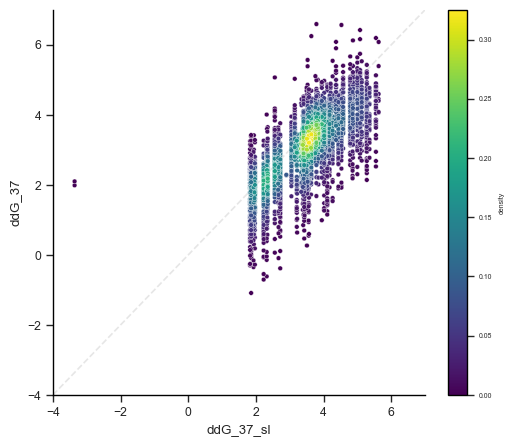

In [13]:
plotting.plot_colored_scatter_comparison(data=df, y='ddG_37', x='ddG_37_sl', 
                                         lim = (-4, 7), color_by_density=True, palette='viridis')
util.save_fig('./fig/Fig3/mismatch/mm_ddG_scatter_density.pdf')

It gets worse if we look at each mismatch separately:

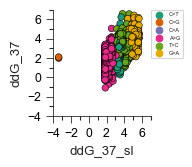

In [14]:
palette = np.array([
    [131,164,255],
    [249,126,43],
    [219,101,210],
    [124,14,221],
    [148,94,234],
]) / 256.
# palette_dict = {mismatch:color for mismatch,color in zip(['A>G', 'C>T'])}

matplotlib.rc('axes',edgecolor='k', linewidth=.5)
fig, (ax, lax) = plt.subplots(1,2,figsize=(4.25*cm, 3.5*cm), gridspec_kw={"width_ratios":[5,1]})
ax.tick_params(colors='k', width=.5)

lim = (-4, 7)
ax.set_xlim(lim)
ax.set_ylim(lim)
sns.scatterplot(data=df, y='ddG_37', x='ddG_37_sl', hue='mismatch', ax=ax, marker='o', edgecolor='k',
                                          palette='Dark2')
sns.despine(trim=False)
ax.xaxis.set_major_locator(MultipleLocator(2))
ax.yaxis.set_major_locator(MultipleLocator(2))
ax.xaxis.set_minor_locator(MultipleLocator(1))
ax.yaxis.set_minor_locator(MultipleLocator(1))

ax.get_legend().remove()
h,l = ax.get_legend_handles_labels()
lax.legend(h,l, borderaxespad=0, prop={'size': 4})
lax.axis("off")

util.save_fig('./fig/Fig3/mismatch/mm_ddG_scatter_colored_by_mismatch.pdf')

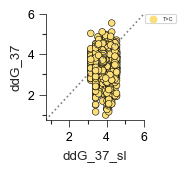

In [15]:
matplotlib.rc('axes',edgecolor='k', linewidth=.5)
fig, (ax, lax) = plt.subplots(1,2,figsize=(4.25*cm, 3.5*cm), gridspec_kw={"width_ratios":[5,1]})
ax.tick_params(colors='k', width=.5)

lim = (.75, 6)
ax.set_xlim(lim)
ax.set_ylim(lim)
ax.plot(lim, lim, ':', c='gray')
sns.scatterplot(data=df.query('mismatch == "T>C"'), y='ddG_37', x='ddG_37_sl', hue='mismatch', ax=ax, marker='o', edgecolor='k', 
                                          palette=np.array([[252,223,120]])/256.)
sns.despine()
ax.xaxis.set_major_locator(MultipleLocator(2))
ax.yaxis.set_major_locator(MultipleLocator(2))
ax.xaxis.set_minor_locator(MultipleLocator(1))
ax.yaxis.set_minor_locator(MultipleLocator(1))

ax.get_legend().remove()
h,l = ax.get_legend_handles_labels()
lax.legend(h,l, borderaxespad=0, prop={'size': 4})
lax.axis("off")

util.save_fig('./fig/Fig3/mismatch/mm_ddG_scatter_T>C.pdf')

### Histogram grid

`df -> ddG_df`

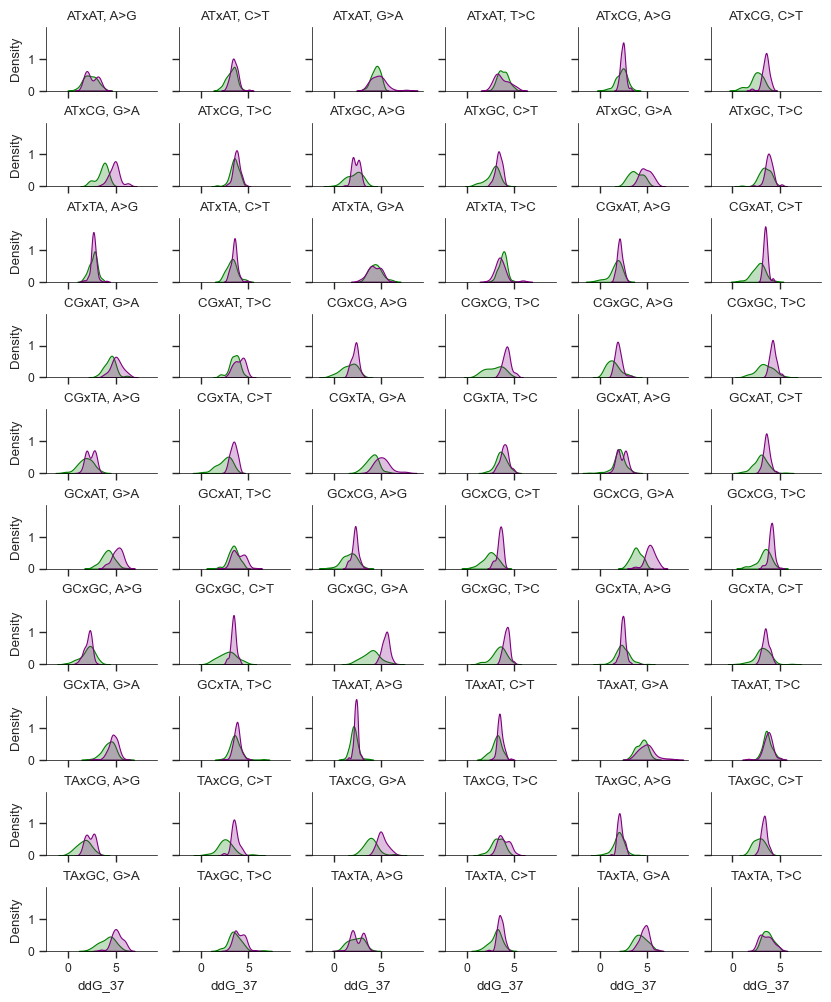

In [17]:
kwargs = dict(fill=True)
flanks, mismatches = np.unique(df.flank), np.unique(df.mismatch)

fig, ax = plt.subplots(10,6,figsize=(10,12), sharey=True, sharex=True)
ax = ax.flatten()

i = 0
ddG_df = pd.DataFrame(columns=['mm', 'ddG_37', 'dop'])

for f in flanks:
    for m in mismatches:
        query = f'flank == "{f}" & mismatch == "{m}"'
        tmp_df = df.query(query).reset_index()
        
        if len(tmp_df) > 10:
            ddG_37_sl_bt = variance.bootstrap_ddG_37_sl(tmp_df)
            sl_bt_df = pd.DataFrame(dict(ddG_37=ddG_37_sl_bt, mm=f'{f}, {m}', dop='sl'))
            arr_ddG_df = pd.DataFrame(dict(ddG_37=tmp_df.ddG_37, mm=f'{f}, {m}', dop='arr'))
            ddG_df = pd.concat([ddG_df, arr_ddG_df, sl_bt_df])
            
            kwargs['ax'] = ax[i]
            ax[i].set_title(f'{f}, {m}')
            sns.kdeplot(tmp_df.ddG_37, label='array melt measurement', color='green', **kwargs)
            sns.kdeplot(ddG_37_sl_bt, label='SantaLucia + measurement error', color='purple', **kwargs)
            sns.despine()
            i += 1
        
# plt.legend()
plt.subplots_adjust(hspace=.5)

util.save_fig('./fig/Fig3/mismatch/mm_spread_hist.pdf')

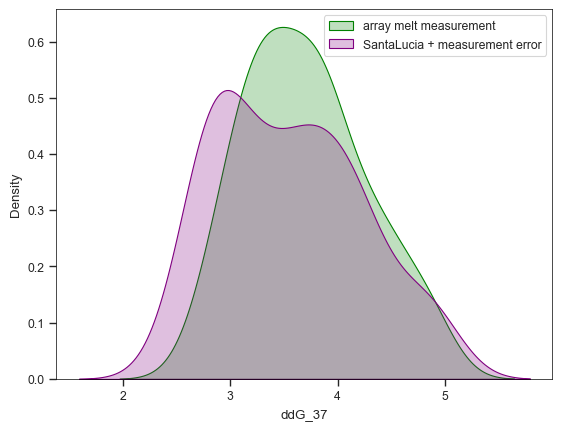

In [18]:
## for legend only ##
kwargs = dict(fill=True)
sns.kdeplot(tmp_df.ddG_37, label='array melt measurement', color='green', **kwargs)
sns.kdeplot(ddG_37_sl_bt, label='SantaLucia + measurement error', color='purple', **kwargs)
plt.legend()
util.save_fig('./fig/Fig3/mismatch/mm_spread_hist_legend.pdf')

### All sorts of variances

`df -> var_df`

In [7]:
var

{'tot': 0.5063020456717048,
 'model': 0.08929841508368057,
 'tech': 0.3245808357401973,
 'bio': 0.18172120993150748,
 'res': 1.3915305315106572,
 '?': 1.0669496957704598}

tot	model	tech	bio	res	?
1.07	0.98	0.15	0.93	0.77	0.62	


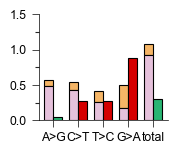

In [34]:
fig, ax = plt.subplots(figsize=(4.25*cm,3.5*cm))
matplotlib.rc('axes',edgecolor='k', linewidth=.5)

mm_list = ['A>G', 'C>T', 'T>C', 'G>A']

metric_dict = dict()
for i,mm in enumerate(mm_list):
    tmp_df = df.query('mismatch == "%s"' % mm)
    y, sigma, y_hat = tmp_df.ddG_37.values, tmp_df.ddG_37_se.values, tmp_df.ddG_37_sl.values
    var = variance.get_variances(y, sigma, y_hat, regress_sigma=False, verbose=False)
    variance.plot_variances(var, i, ax=ax, label_text=False, legend=False)
    metric_dict[mm] = (var['bio'] - var['?']) / var['bio']
    plt.axhline(0, color='k', linewidth=.5)
    ax.yaxis.set_major_locator(MultipleLocator(.5))
    ax.yaxis.set_minor_locator(MultipleLocator(.1))
    ax.tick_params(colors='k', width=.5)
    ax.set_ylim([0,1.5])
    
y = df.ddG_37.values
y_hat = df.ddG_37_sl.values
sigma = df.ddG_37_se.values
var= variance.get_variances(y, sigma, y_hat, verbose=True)
variance.plot_variances(var, i+1, ax, label_text=False)

ax.set_xticks(np.arange(5), mm_list + ['total'])
ax.xaxis.set_major_locator(MultipleLocator(1))
ax.yaxis.set_major_locator(MultipleLocator(.5))
ax.yaxis.set_minor_locator(MultipleLocator(.25))

util.save_fig('./fig/Fig3/mismatch/mm_variance_bar_by_mismatch.pdf')

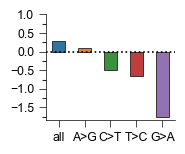

In [544]:
metric_fun = lambda y,y_hat: r2_score(y,y_hat)
metric_dict = dict()
metric_dict['all'] = metric_fun(df.ddG_37, df.ddG_37_sl)
for i,mm in enumerate(['A>G', 'C>T', 'T>C', 'G>A']):
    tmp_df = df.query('mismatch == "%s"' % mm)
    y, sigma, y_hat = tmp_df.ddG_37.values, tmp_df.ddG_37_se.values, tmp_df.ddG_37_sl.values
    metric_dict[mm] = metric_fun(y, y_hat)

fig, ax = plt.subplots(figsize=(4.25*cm, 3.5*cm))
matplotlib.rc('axes',edgecolor='k', linewidth=.5)
ax.tick_params(colors='k', width=.5)

metric_df = pd.DataFrame(metric_dict, index=['metric value'])
sns.barplot(metric_df, ax=ax, width=.5, linewidth=.5, edgecolor='k')
plt.axhline(0, color='k', linestyle=':')
ax.yaxis.set_major_locator(MultipleLocator(.5))
ax.yaxis.set_minor_locator(MultipleLocator(.25))
ax.set_ylim(top=1)
sns.despine()

util.save_fig('./fig/Fig3/mismatch/mm_r2_bar_by_mismatch.pdf')

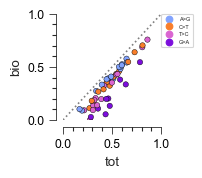

In [388]:
matplotlib.rc('axes',edgecolor='k', linewidth=.5)
fig, (ax, lax) = plt.subplots(1,2,figsize=(4.25*cm, 3.5*cm), gridspec_kw={"width_ratios":[5,1]})
ax.tick_params(colors='k', width=.5)

lim=[0,1]
ax.plot(lim, lim, ':', c='gray')
sns.scatterplot(data=var_df, x='tot', y='bio',  ax=ax, s=15, edgecolor='k',
                                         hue='mismatch', palette=palette)
ax.set_xlim(lim)
ax.set_ylim(lim)
sns.despine(offset=5)
ax.xaxis.set_major_locator(MultipleLocator(.5))
ax.yaxis.set_major_locator(MultipleLocator(.5))
ax.xaxis.set_minor_locator(MultipleLocator(.1))
ax.yaxis.set_minor_locator(MultipleLocator(.1))

ax.get_legend().remove()
h,l = ax.get_legend_handles_labels()
lax.legend(h,l, borderaxespad=0, prop={'size': 4})
lax.axis("off")

util.save_fig('./fig/Fig3/mismatch/mm_variance_bio_vs_tot.pdf')

# Variance per position

In [4]:
import statsmodels.api as sm
from statsmodels.formula.api import ols

## Single mismatches

### ddG

In [9]:
arr = pd.read_csv('./data/models/raw/arr_v0_n=30680.csv', index_col=0)
arr_mm = arr.query("Series == 'MisMatches'")

## find parents ##
df_with_parent = pd.concat(
    [variance.find_mm_parent_df(arr_mm, arr, '5p'), variance.find_mm_parent_df(arr_mm, arr, '3p')],
    axis=0
)

df_with_parent.drop_duplicates(inplace=True)

### Individual positions

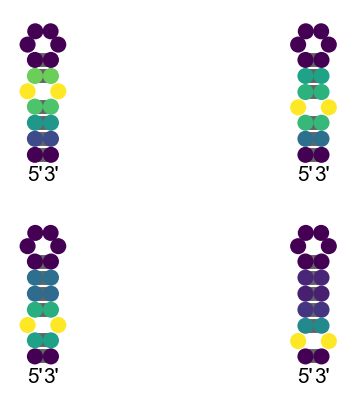

In [10]:
fig, ax = plt.subplots(2,2)
ax = ax.flatten()

df = df_with_parent.copy()
n = len(df_with_parent.TargetStruct.values[0])
c_log = np.zeros((len(np.unique(df['TargetStruct'])), n))

for ind, target_struct in enumerate(np.unique(df['TargetStruct'])):
    n = len(target_struct)
    tmp_df = df[df.TargetStruct == target_struct]
    anova_df = variance.get_pos_df(tmp_df, n=n)

    contributions = dict()
    for pos_col in anova_df.columns[:-1]:
        contributions[pos_col] = variance.get_sum_sq_explained(anova_df, pos_col, y_col='ddG_37')

    c = np.zeros(n)
    for key,value in contributions.items():
        p = int(key.replace('p',''))
        c[p] = np.log(value)
    c_log[ind, :] = c
    
    draw_struct(' '*n, target_struct, c=c, cmap='viridis', ax=ax[ind])
    
util.save_fig('./fig/Fig3/importance/single_mm_importance.pdf')

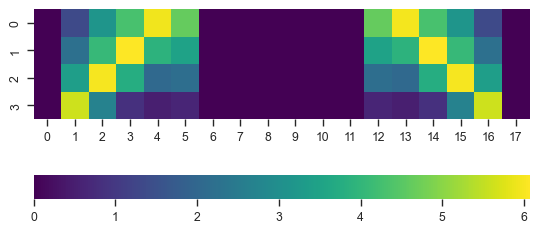

In [11]:
### For the scale bar
sns.heatmap(c_log, cmap='viridis', square=True,
            cbar_kws=dict(orientation='horizontal'))

util.save_fig('./fig/Fig3/importance/single_mm_importance_heatmap.pdf')

In [12]:
explained_ratio_indep = np.sum(list(contributions.values())) / np.sum((anova_df.ddG_37 - np.mean(anova_df.ddG_37))**2)
print("%.1f%% of total variance is explained by single nucleotides" % (explained_ratio_indep *100))

74.3% of total variance is explained by single nucleotides


### Pairwise

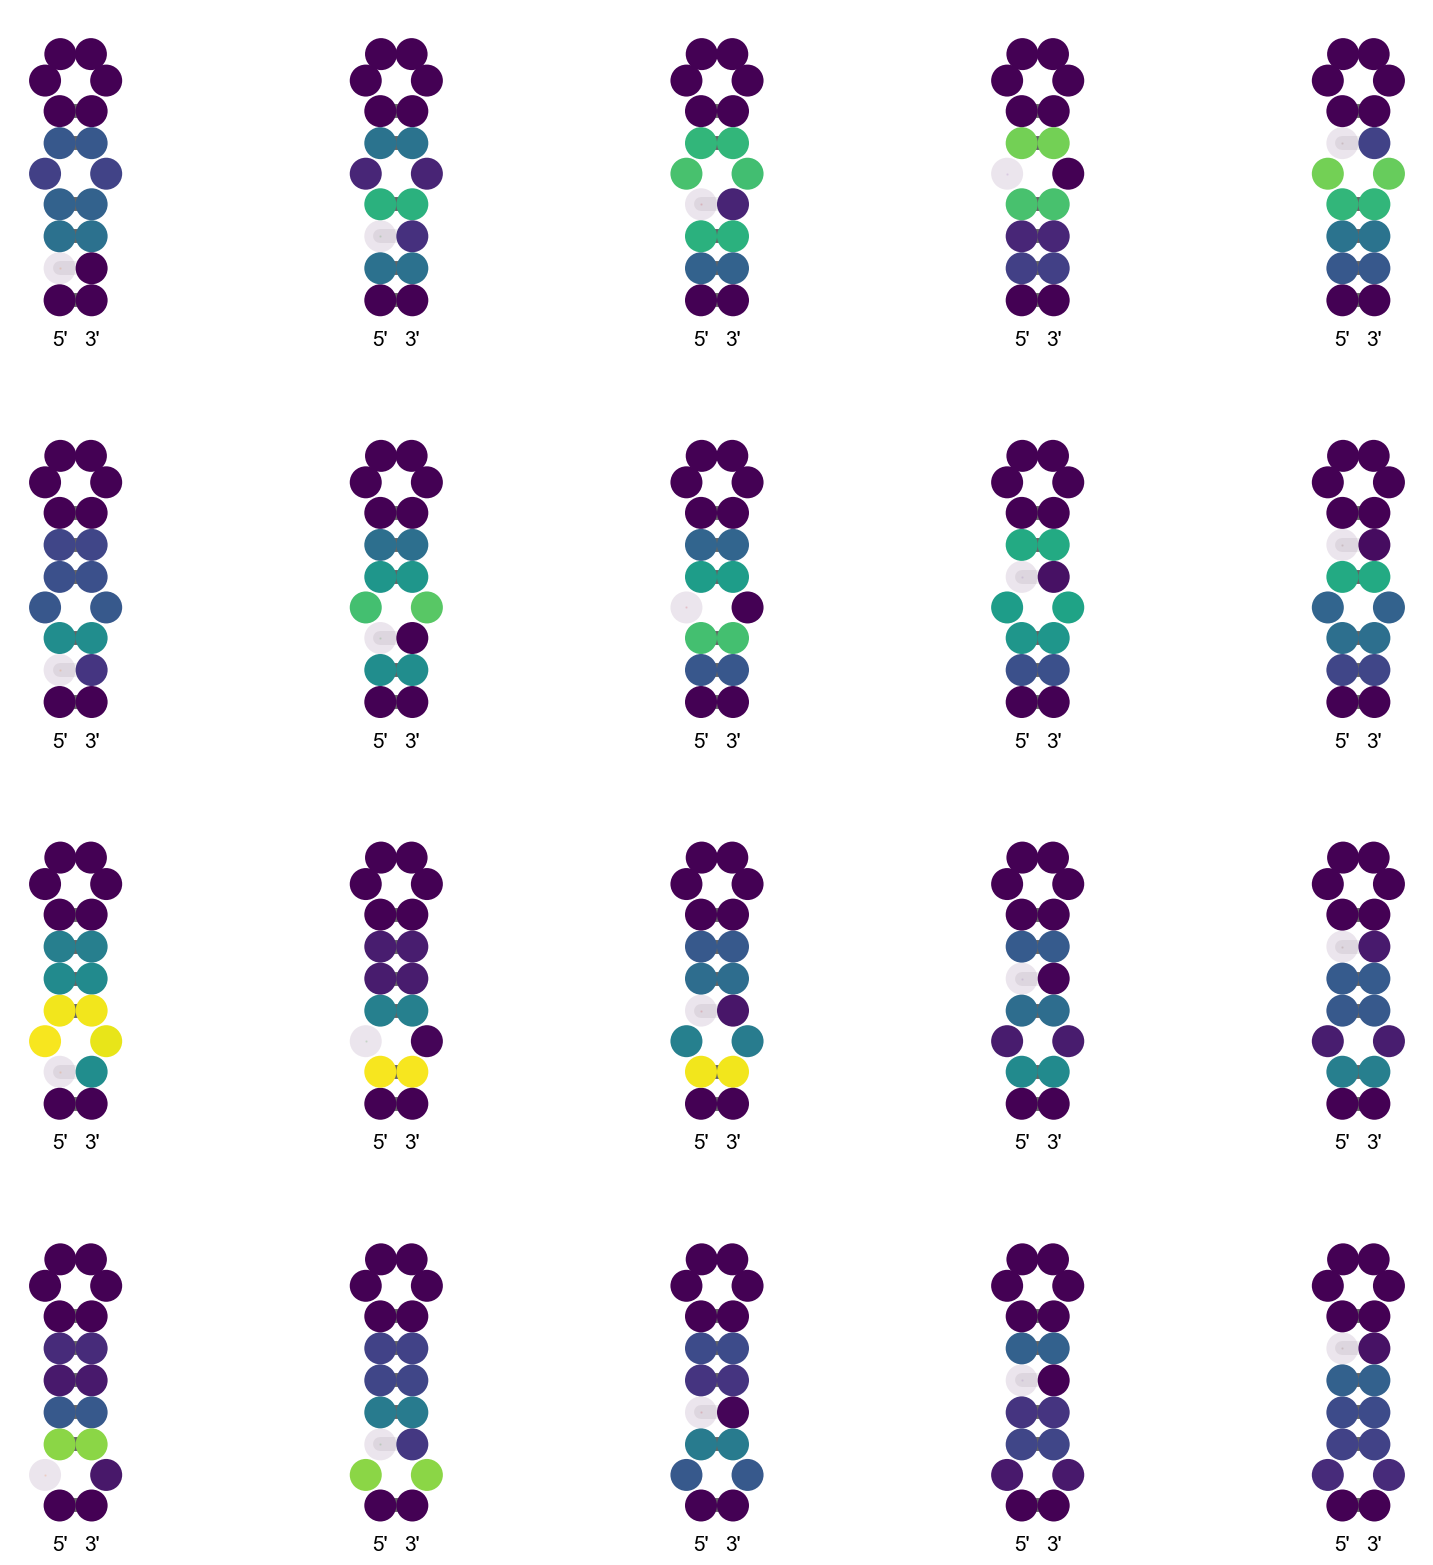

In [20]:
fig, ax = plt.subplots(4,5, figsize=(20,20))
# ax = ax.flatten()

df = df_with_parent.copy()
n = len(df['TargetStruct'].values[0])

contributions = dict()

for ind, target_struct in enumerate(np.unique(df['TargetStruct'])):
    tmp_df = df[df.TargetStruct == target_struct]
    n = len(target_struct)
    anova_df = variance.get_pos_df(tmp_df, n=n)
    pos_cols = [c for c in anova_df.columns if c.startswith('p')]
    
    c_mat = np.zeros((n,n))
    for i,pair in enumerate(itertools.combinations(pos_cols, 2)):
        v = variance.get_extra_explained_cp(tmp_df, pair[0], pair[1], y_col='ddG_37')
        pos1, pos2 = pair[0].replace('p',''), pair[1].replace('p','')
        c_mat[int(pos1), int(pos2)] = v
        contributions[pair] = v

    c_mat_sym = c_mat + c_mat.T
    # print(np.max(c_mat_sym.flatten()))
    for p in range(5):
        alpha = np.ones(n)
        alpha[p+1] = 0.1
        draw_struct(' '*n, target_struct, c=c_mat_sym[p+1,:], alpha=alpha,
                    cmap='viridis', vmin=0, vmax=0.03,
                    ax=ax[ind, p])

util.save_fig('./fig/Fig3/importance/single_mm_importance_pairwise.pdf')

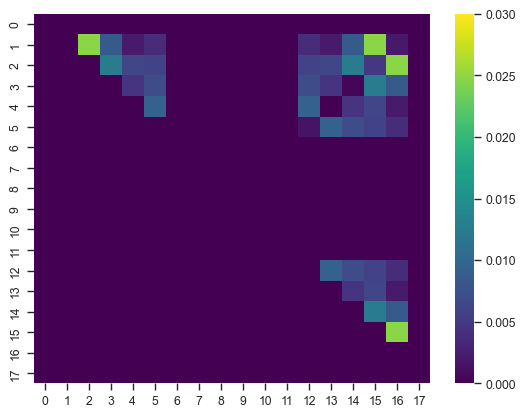

In [21]:
sns.heatmap(c_mat, cmap='viridis', vmin=0, vmax=0.03)
util.save_fig('./fig/Fig3/importance/single_mm_importance_pairwise_cbar.pdf')

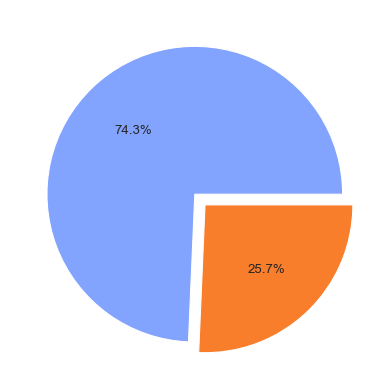

In [524]:
# Ah cannot calculate higher order in this way
plt.pie([explained_ratio_indep, 1 - explained_ratio_indep],
        explode=[0,.1],
        colors=np.array([
    [131,164,255],
    [249,126,43],
]) / 256.,
       autopct=lambda x: '%.1f%%'%(x))
util.save_fig('./fig/Fig3/importance/single_mm_variance_individual_vs_higher_order.pdf')

## Individual positions for hairpin loops

### All dG

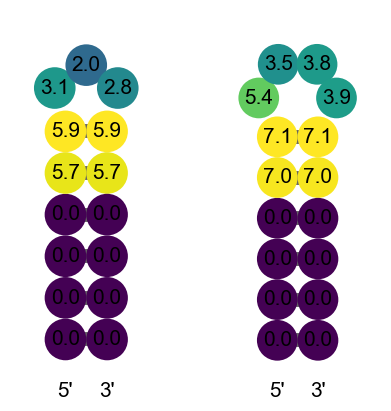

In [167]:
fig, ax = plt.subplots(1,2,figsize=(5,5))
ax = ax.flatten()

all_hp_df = arr.query('(Series == "TETRAloop" | Series == "TRIloop") & ConstructType == "NNN"')
target_structs = np.unique(all_hp_df.TargetStruct.values)

for i,target_struct in enumerate(target_structs):
    hp_df = all_hp_df.query('TargetStruct == "%s"'%target_struct)
    variance.calc_and_plot_hp_contributions_on_struct(hp_df, arr, y_col='dG_37', ax=ax[i])
    
util.save_fig('./fig/Fig3/importance/hairpinloop_variance_dG.pdf', fig=fig)

### All ddG

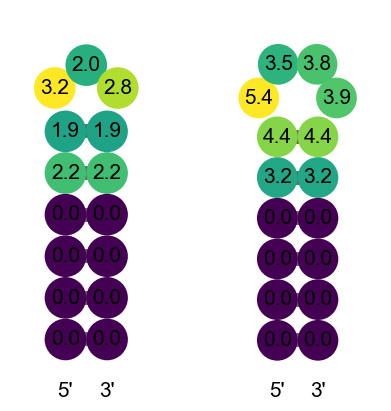

In [169]:
fig, ax = plt.subplots(1,2,figsize=(5,5))
ax = ax.flatten()

all_hp_df = arr.query('(Series == "TETRAloop" | Series == "TRIloop") & ConstructType == "NNN"')
target_structs = np.unique(all_hp_df.TargetStruct.values)

for i,target_struct in enumerate(target_structs):
    hp_df = all_hp_df.query('TargetStruct == "%s"'%target_struct)
    
    loop_len = target_struct.count('.')
    if loop_len == 3:
        ref_loop_seq = 'TTT'
    elif loop_len == 4:
        ref_loop_seq = 'TAAA'
        
    variance.calc_and_plot_hp_contributions_on_struct(hp_df, arr, y_col='ddG_37', 
                                                      ref_loop_seq=ref_loop_seq, ax=ax[i])
    
util.save_fig('./fig/Fig3/importance/hairpinloop_variance_ddG.pdf', fig=fig)

## Tetraloops

In [212]:
arr = pd.read_csv('./data/models/raw/arr_v0_n=30680.csv', index_col=0)
df_nnn = arr.query('Series == "TETRAloop" & ConstructType == "NNN"')

### ddG

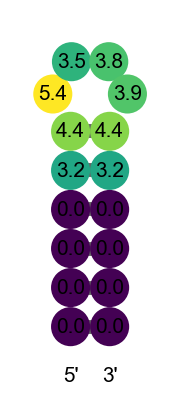

In [126]:
ref_loop_seq = 'TAAA'

variance.calc_and_plot_hp_contributions_on_struct(df_nnn, arr, ref_loop_seq=ref_loop_seq, y_col='ddG_37')
util.save_fig('./fig/Fig3/importance/tetraloop_variance_ddG.pdf', fig=fig)

### dG

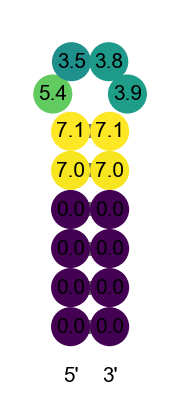

In [135]:
variance.calc_and_plot_hp_contributions_on_struct(df_nnn, arr, y_col='dG_37')
util.save_fig('./fig/Fig3/importance/tetraloop_variance_dG.pdf')

### Pairwise

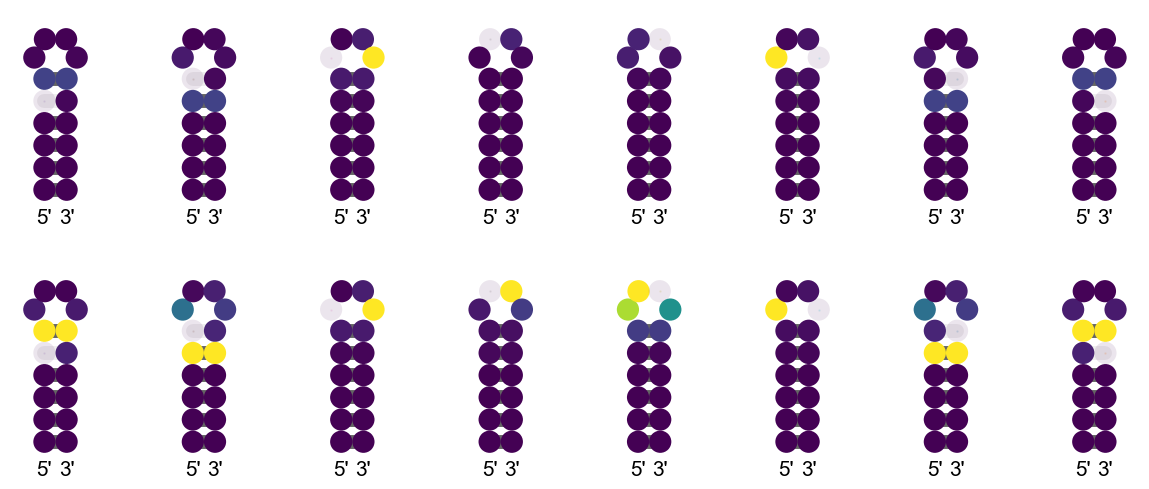

In [213]:
df_with_parent = variance.find_hp_parent_df(df_nnn, arr, ref_loop_seq='TAAA')
target_struct = df_with_parent['TargetStruct'].values[0]
n_var_pos = 8
fig, ax = plt.subplots(2,n_var_pos, figsize=(15,6))

df = df_with_parent.copy()
n = len(df['TargetStruct'].values[0])

contributions = dict()

tmp_df = df[df.TargetStruct == target_struct]
n = len(target_struct)
anova_df = variance.get_pos_df(tmp_df, n=n)
pos_cols = [c for c in anova_df.columns if c.startswith('p')]

c_mat = np.zeros((n,n))
for i,pair in enumerate(itertools.combinations(pos_cols, 2)):
    v = variance.get_extra_explained_cp(tmp_df, pair[0], pair[1], y_col='dG_37')
    pos1, pos2 = pair[0].replace('p',''), pair[1].replace('p','')
    c_mat[int(pos1), int(pos2)] = v
    contributions[pair] = v

c_mat_sym = c_mat + c_mat.T

vmax = np.max(c_mat_sym.flatten())
    
for ind in range(2):

    for i in range(n_var_pos):
        p = i + 4
        alpha = np.ones(n)
        alpha[p] = 0.1
        
        if ind == 0:
            draw_struct(' '*n, target_struct, c=c_mat_sym[p,:], alpha=alpha,
                        cmap='viridis', vmin=0, vmax=vmax,
                        ax=ax[ind, i])
        elif ind == 1:
            draw_struct(' '*n, target_struct, c=c_mat_sym[p,:], alpha=alpha,
                        cmap='viridis', vmin=0, 
                        ax=ax[ind, i])

util.save_fig('./fig/Fig3/importance/tetraloop_importance_pairwise.pdf')

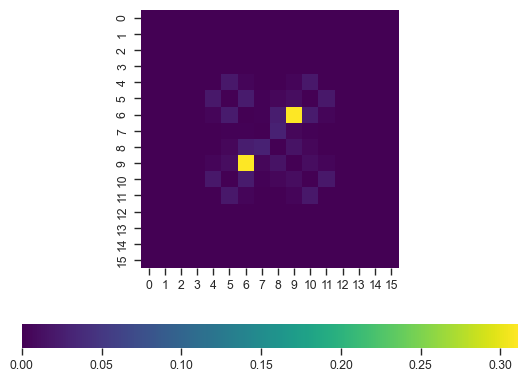

In [206]:
### For the scale bar
sns.heatmap(c_mat_sym, cmap='viridis', square=True, vmax=vmax,
            cbar_kws=dict(orientation='horizontal'))

util.save_fig('./fig/Fig3/importance/tetraloop_importance_heatmap.pdf')

## Triloops

In [207]:
arr = pd.read_csv('./data/models/raw/arr_v0_n=30680.csv', index_col=0)
df_nnn = arr.query('Series == "TRIloop" & ConstructType == "NNN"')

### ddG

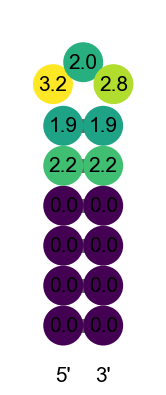

In [165]:
ref_loop_seq = 'TTT'

variance.calc_and_plot_hp_contributions_on_struct(df_nnn, arr, ref_loop_seq=ref_loop_seq, y_col='ddG_37')
util.save_fig('./fig/Fig3/importance/triloop_variance_ddG.pdf', fig=fig)

### dG

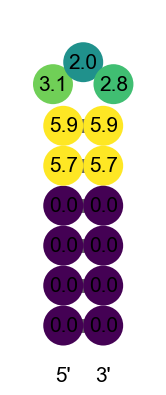

In [137]:
variance.calc_and_plot_hp_contributions_on_struct(df_nnn, arr, y_col='dG_37', clip_max=4)
util.save_fig('./fig/Fig3/importance/triloop_variance_dG.pdf')

### Pairwise

In [187]:
def score_fmt(x):
    if x > 1e-6:
        return '%.1f'%x
    else:
        return ' '

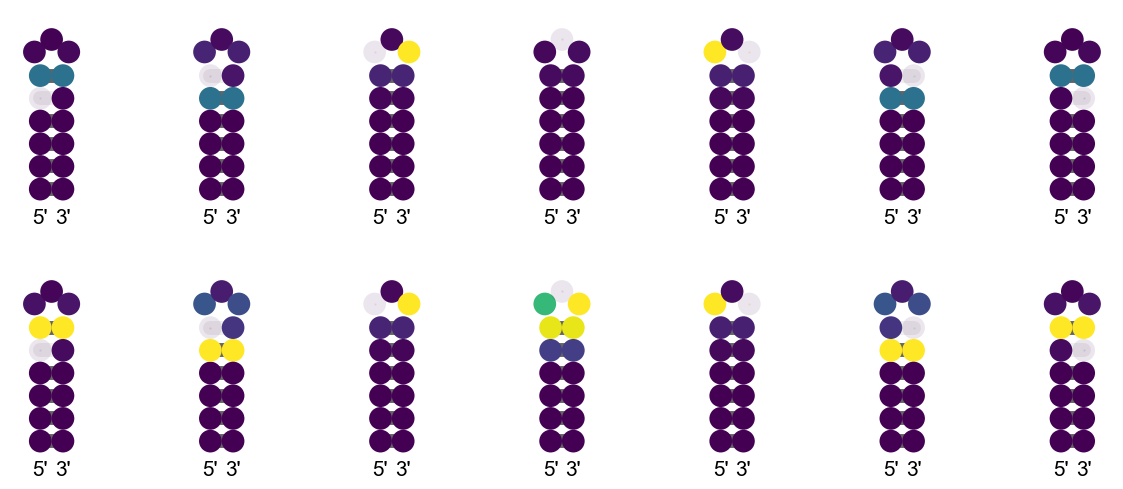

In [210]:
df_with_parent = variance.find_hp_parent_df(df_nnn, arr, ref_loop_seq='TTT')
target_struct = df_with_parent['TargetStruct'].values[0]

fig, ax = plt.subplots(2,7, figsize=(15,6))
# ax = ax.flatten()

df = df_with_parent.copy()
n = len(df['TargetStruct'].values[0])

contributions = dict()

tmp_df = df[df.TargetStruct == target_struct]
n = len(target_struct)
anova_df = variance.get_pos_df(tmp_df, n=n)
pos_cols = [c for c in anova_df.columns if c.startswith('p')]

c_mat = np.zeros((n,n))
for i,pair in enumerate(itertools.combinations(pos_cols, 2)):
    v = variance.get_extra_explained_cp(tmp_df, pair[0], pair[1], y_col='dG_37')
    pos1, pos2 = pair[0].replace('p',''), pair[1].replace('p','')
    c_mat[int(pos1), int(pos2)] = v
    contributions[pair] = v

c_mat_sym = c_mat + c_mat.T

vmax = np.max(c_mat_sym.flatten())
    
for ind in range(2):

    for i in range(7):
        p = i + 4
        alpha = np.ones(n)
        alpha[p] = 0.1
        
        if ind == 0:
            draw_struct(' '*n, target_struct, c=c_mat_sym[p,:], alpha=alpha,
                        cmap='viridis', vmin=0, vmax=vmax,
                        ax=ax[ind, i])
        elif ind == 1:
            # text_lbl = [score_fmt(x) for x in c_mat_sym[p,:]]
            draw_struct(' '*n, target_struct, c=c_mat_sym[p,:], alpha=alpha,
                        cmap='viridis', vmin=0, 
                        ax=ax[ind, i])

util.save_fig('./fig/Fig3/importance/triloop_importance_pairwise.pdf')

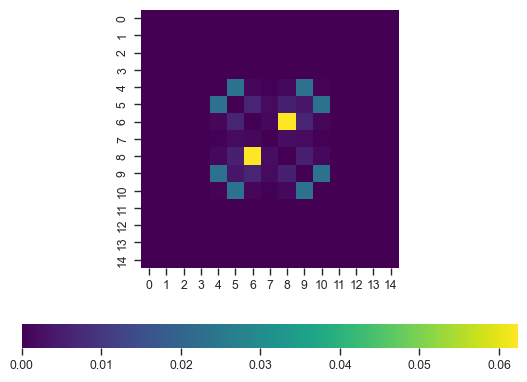

In [211]:
### For the scale bar
sns.heatmap(c_mat_sym, cmap='viridis', square=True, vmax=vmax,
            cbar_kws=dict(orientation='horizontal'))

util.save_fig('./fig/Fig3/importance/triloop_importance_heatmap.pdf')

## Bulges

In [38]:
arr = pd.read_csv('./data/models/raw/arr_v0_n=30680.csv', index_col=0)
df_nnn = arr.query('Series == "Bulges" & (ConstructType == "NNN_3primebulge" | ConstructType == "NNN_5prime_bulge")')

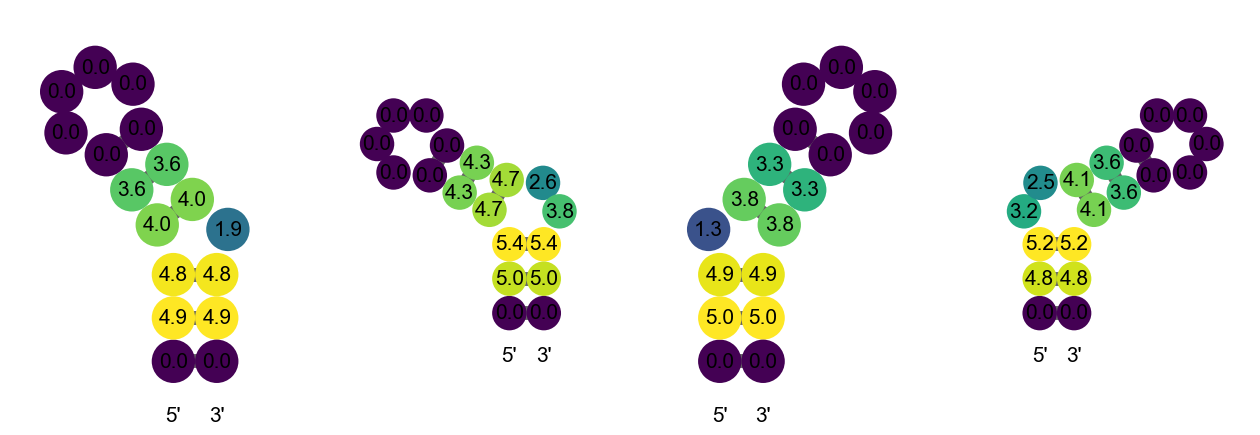

In [42]:
fig, ax = plt.subplots(1,4, figsize=(16,7))

for i,target_struct in enumerate(np.unique(df_nnn.TargetStruct)):
    contributions = variance.get_single_nt_contributions_df(df_nnn.query('TargetStruct == "%s"'%target_struct), y_col='dG_37')
    variance.plot_contributions_on_struct(contributions, target_struct, log_scale=True, ax=ax[i])
    
util.save_fig('./fig/Fig3/importance/bulge_importance.pdf')

0.031524165015885175
0.055869904953263605
0.03936997038029344
0.057072930705357794


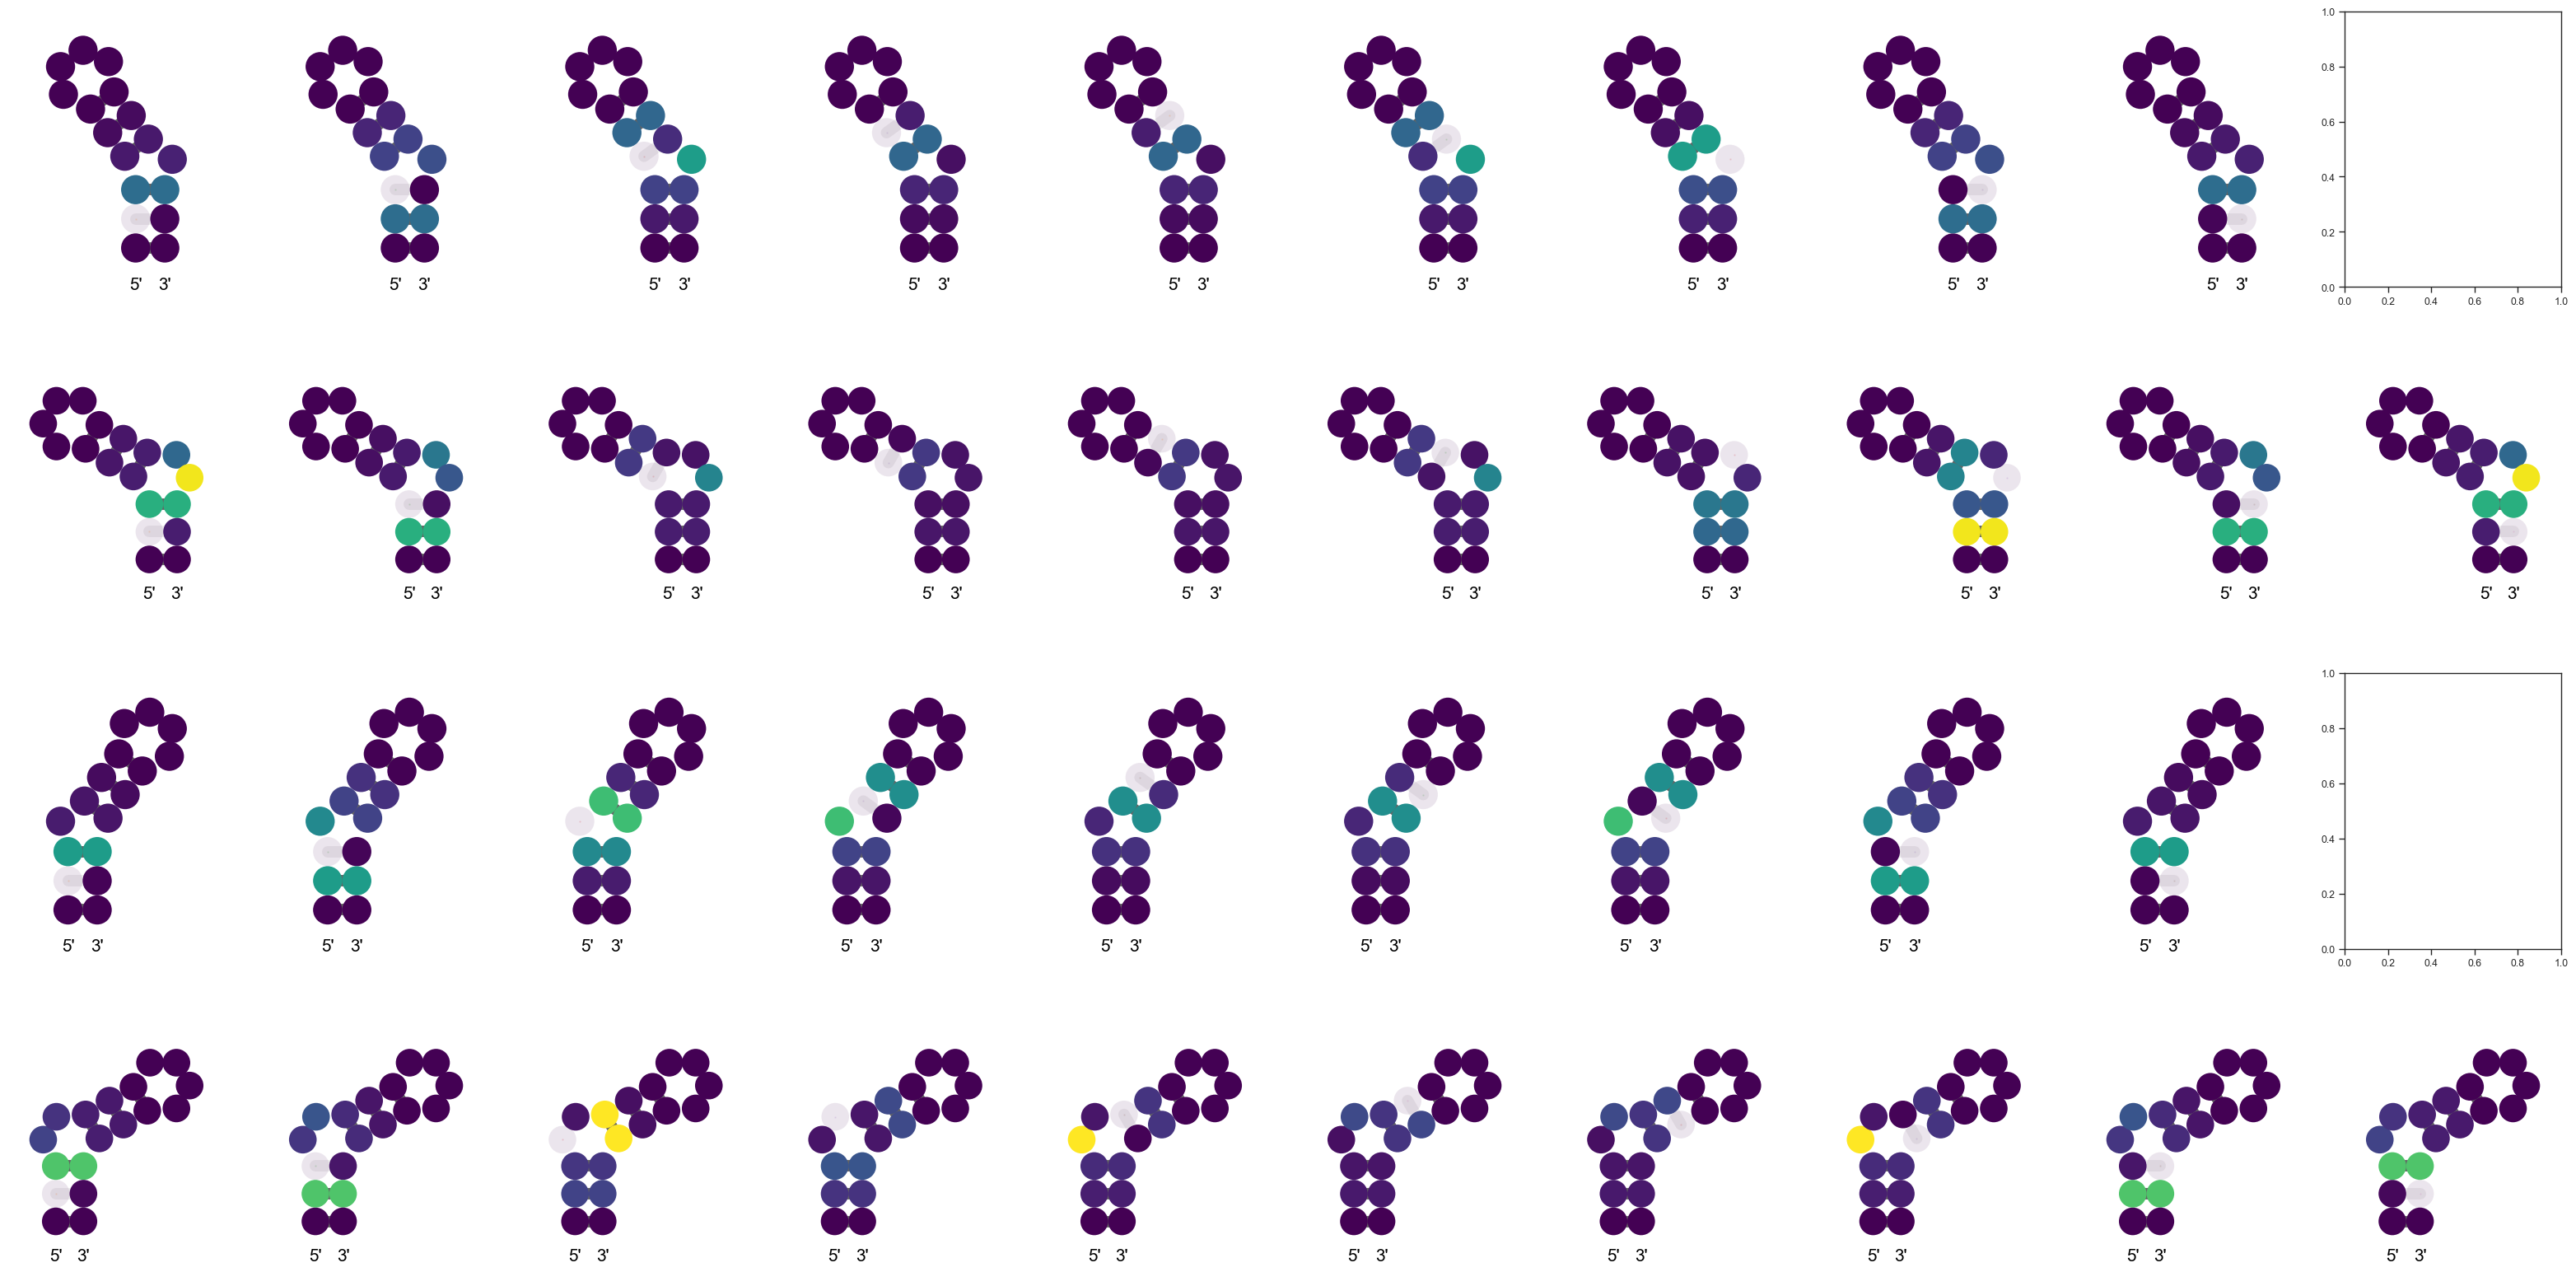

In [43]:
n_pair = 10
fig, ax = plt.subplots(4,n_pair, figsize=(40,20))
# ax = ax.flatten()

df = df_nnn.copy()
n = len(df['TargetStruct'].values[1])

contributions = dict()

for ind, target_struct in enumerate(np.unique(df['TargetStruct'])):
    tmp_df = df[df.TargetStruct == target_struct]
    n = len(target_struct)
    anova_df = variance.get_pos_df(tmp_df, n=n, y_col='dG_37')
    pos_cols = [c for c in anova_df.columns if c.startswith('p')]
    
    c_mat = np.zeros((n,n))
    for i,pair in enumerate(itertools.combinations(pos_cols, 2)):
        v = variance.get_extra_explained_cp(tmp_df, pair[0], pair[1], y_col='dG_37')
        pos1, pos2 = pair[0].replace('p',''), pair[1].replace('p','')
        c_mat[int(pos1), int(pos2)] = v
        contributions[pair] = v

    c_mat_sym = c_mat + c_mat.T
    print(np.max(c_mat_sym.flatten()))
    k = 0
    for p in [int(x.replace('p','')) for x in pos_cols]:
        alpha = np.ones(n)
        alpha[p] = 0.1
        draw_struct(' '*n, target_struct, c=c_mat_sym[p,:], alpha=alpha,
                    cmap='viridis', vmin=0, vmax=0.057,
                    ax=ax[ind, k])
        k += 1

util.save_fig('./fig/Fig3/importance/bulge_importance_pairwise.pdf')

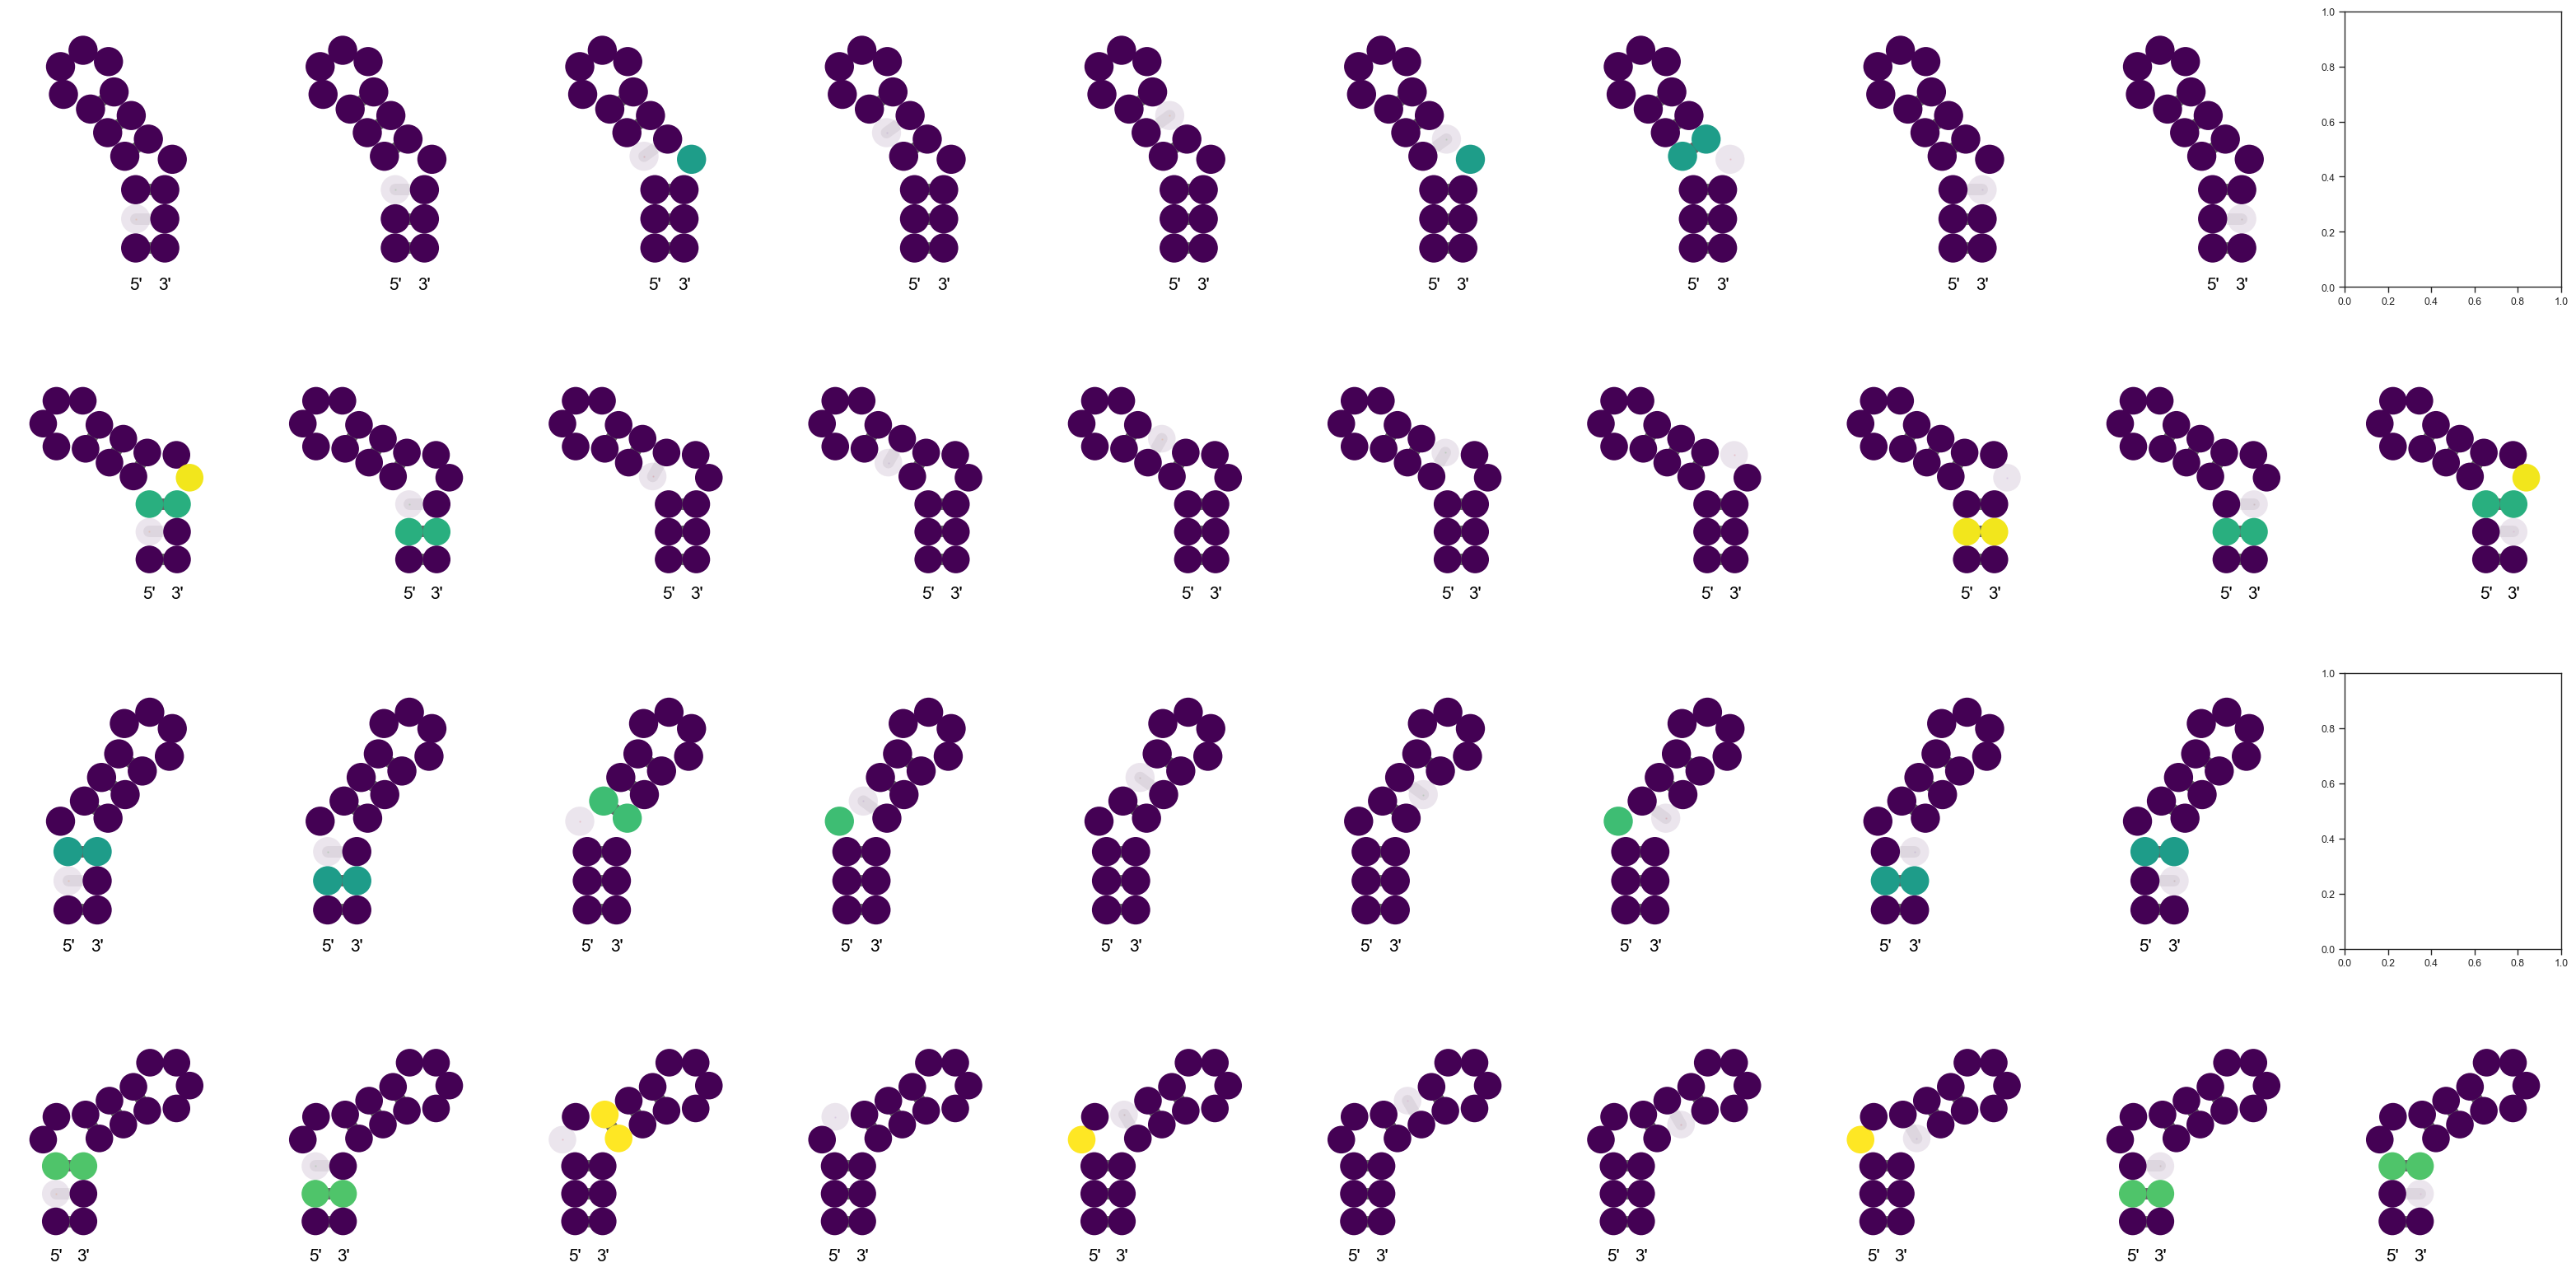

In [44]:
fig, ax = plt.subplots(4,n_pair, figsize=(40,20))

for ind, target_struct in enumerate(np.unique(df['TargetStruct'])):
    tmp_df = df[df.TargetStruct == target_struct]
    n = len(target_struct)
    anova_df = variance.get_pos_df(tmp_df, n=n, y_col='dG_37')
    pos_cols = [c for c in anova_df.columns if c.startswith('p')]
    
    c_mat = np.zeros((n,n))
    for i,pair in enumerate(itertools.combinations(pos_cols, 2)):
        v = variance.get_extra_explained_cp(tmp_df, pair[0], pair[1], y_col='dG_37')
        pos1, pos2 = pair[0].replace('p',''), pair[1].replace('p','')
        c_mat[int(pos1), int(pos2)] = v
        contributions[pair] = v

    c_mat_sym = c_mat + c_mat.T
    # print(np.max(c_mat_sym.flatten()))
    c_mat_sym[c_mat_sym < 0.03] = 0
    k = 0
    for p in [int(x.replace('p','')) for x in pos_cols]:
        alpha = np.ones(n)
        alpha[p] = 0.1
        draw_struct(' '*n, target_struct, c=c_mat_sym[p,:], alpha=alpha,
                    cmap='viridis', vmin=0, vmax=0.057,
                    ax=ax[ind, k])
        k += 1
        
util.save_fig('./fig/Fig3/importance/bulge_importance_pairwise_thresh.pdf')